In [15]:
import math
import os
import random
import tempfile
from typing import Any, Callable, Dict, Iterator, List, Optional, Tuple, Union

import matplotlib.pylab as plt
import numpy as np
import requests
import torch
from rasterio.crs import CRS
from torch.utils.data import DataLoader
from torchgeo.datasets import (
    NAIP,
    BoundingBox,
    ChesapeakeDE,
    GeoDataset,
    RasterDataset,
    stack_samples,
)
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler
from torchgeo.samplers.utils import get_random_bounding_box

## Setup and test regular sampler

In [16]:
class MODIS_CCI(RasterDataset):
    """Abstract class for all MODIS CCI datasets."""


class MODIS_JD(MODIS_CCI):
    filename_glob = "*JD.tif"
    filename_regex = "(?P<date>\d{6})\S{33}(?P<tile_number>\d).*"
    date_format = "%Y%m"
    is_image = False
    all_bands = ["Julian Day"]

    def __init__(
        self,
        root: str = None,
        crs: Optional[CRS] = None,
        res: Optional[float] = None,
        transforms: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
        cache: bool = True,
    ) -> None:
        """Initialize a new Dataset instance.
        Args:
            root: root directory where dataset can be found
            crs: :term:`coordinate reference system (CRS)` to warp to
                (defaults to the CRS of the first file found)
            res: resolution of the dataset in units of CRS
                (defaults to the resolution of the first file found)
            transforms: a function/transform that takes an input sample
                and returns a transformed version
            cache: if True, cache file handle to speed up repeated sampling
        Raises:
            FileNotFoundError: if no files are found in ``root``
        """

        super().__init__(root, crs, res, transforms, cache)

In [17]:
ds = MODIS_JD("Binarized")
print(ds)

MODIS_JD Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=22.944655155023842, maxx=32.100509032624856, miny=50.50204611239522, maxy=53.04421598961974, mint=1583020799.999999, maxt=1590965999.999999)
    size: 3


In [18]:
# NOTE: batch_size = no. samples per batch
#       length = total number of samples per epoch, i.e. length/batch_size = number of  batches of samples taken

sampler = RandomBatchGeoSampler(ds, size=0.5, batch_size=4, length=20)

torch.Size([1, 223, 223])


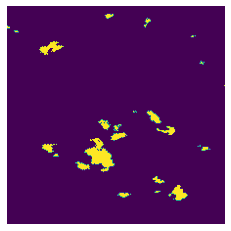

torch.Size([1, 223, 223])


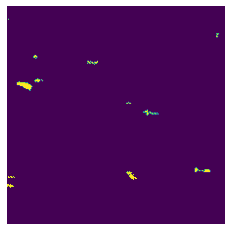

torch.Size([1, 223, 223])


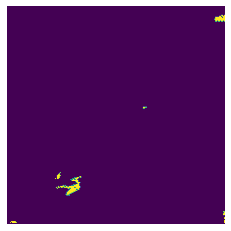

torch.Size([1, 223, 223])


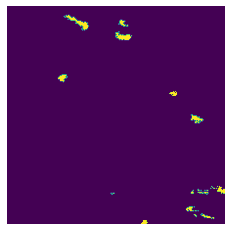

torch.Size([1, 223, 223])


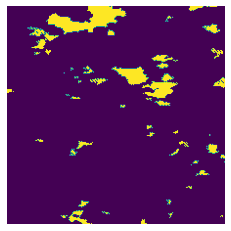

In [19]:
# NOTE: We require the batch_sampler argument now. The samples must also have an extra index to indicate the batch_num to use
dl = DataLoader(ds, batch_sampler=sampler, collate_fn=stack_samples)

for sample in dl:
    mask = sample["mask"][0]
    print(mask.shape)
    ds.plot(mask)

## Make ConstrainedRandomGeoSampler class

In [20]:
class ConstrainedRandomGeoSampler(RandomGeoSampler):
    """Returns samples that meet the constraints specified:
        1. Proportion of samples with a burn proportion < 'burn_th': 'no_burn_prop'
        2. The rest of the samples will make up 1-'no_burn_prop' proportion and have a burn proportion > 'burn_th'

    Args:
        dataset: the dataset to take samples from.
        size: size of patch in lat/lon.
        length: number of samples to take per epoch.
        not_burned_prop: proportion of returned samples present that are "not burned". This may be no burn/some burn.
        burn_th: minimum threshold proportion required for a sample to be classed as "burned.
        roi: region of interest to take samples from.

    Returns:
        constrained_samples: set of samples that meet the specified constraints.
    """

    # Setup the attributes required for constraint implementation
    not_burned_samples_required = None
    burn_samples_required = None
    not_burned_prop = None
    burn_th = None

    # Define the constructor
    def __init__(
        self,
        dataset: MODIS_JD,
        size: Union[Tuple[float, float], float],
        length: int,
        not_burned_prop: float,
        burn_th: float,
        roi: Optional[BoundingBox] = None,
    ) -> None:

        # Use init from RandomGeoSampler parent class
        super().__init__(dataset, size, length)

        # Save the input constraints and dataset to the object
        self.dataset = dataset
        self.not_burned_prop = not_burned_prop
        self.burn_th = burn_th

        # Set the number of samples required of not burned/burned types
        self.not_burned_samples_required = math.floor(not_burned_prop * self.length)
        self.burn_samples_required = self.length - self.not_burned_samples_required

    def __iter__(self) -> Iterator[BoundingBox]:
        """Defines a generator function of areas to sample next.

        Returns:
            (minx, maxx, miny, maxy, mint, maxt) coordinates to index a dataset
        """

        # While we still require more samples, generate random bounding boxes
        while self.not_burned_samples_required != 0 or self.burn_samples_required != 0:

            # Choose a random tile
            hit = random.choice(self.hits)
            bounds = BoundingBox(*hit.bounds)

            # Choose a random sample within that tile
            bounding_box = get_random_bounding_box(bounds, self.size, self.res)

            # Find the burn proportion of that sample
            burn_prop = self.get_burn_proportion(bounding_box)

            # If we have a "not-burned" sample and we require "not-burned" samples
            if burn_prop < self.burn_th and self.not_burned_samples_required != 0:
                # print("No burn sample:")
                self.not_burned_samples_required -= 1
                yield bounding_box

            # If we have a "burn" sample and we require "burn" samples
            elif burn_prop >= self.burn_th and self.burn_samples_required != 0:
                # print("Burn sample:")
                self.burn_samples_required -= 1
                yield bounding_box

        # If all required samples generated, reset requirements for next sampler call
        self.not_burned_samples_required = math.floor(
            self.not_burned_prop * self.length
        )
        self.burn_samples_required = self.length - self.not_burned_samples_required

    def get_burn_proportion(self, bounding_box):
        """Returns the burn proportion found within a given bounding box.

        Returns:
            burn_prop: the burn proportion present within the bounding box.
        """

        # Obtain the burn data within the bounding box
        burn_data = self.dataset[bounding_box]["mask"]

        # Get burn proportion within the bounding box
        non_zero_count = int((np.array(burn_data) > 0).sum())
        burn_prop = non_zero_count / burn_data.numel()
        return burn_prop

In [21]:
# 0.3 is the largest size possible on cropped dataset that burn_th of 0.3 can be had
sampler2 = ConstrainedRandomGeoSampler(
    ds, size=0.2, length=5, not_burned_prop=0.5, burn_th=0.3
)

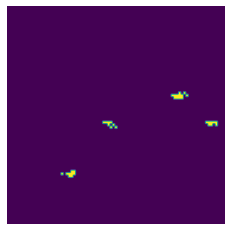

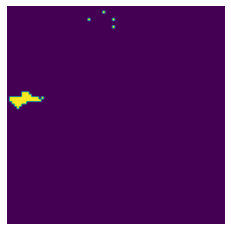

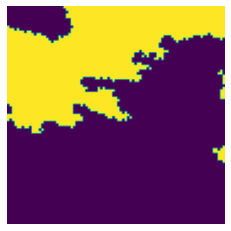

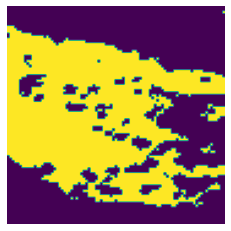

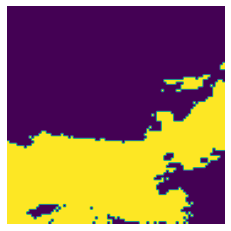

In [22]:
# Why isn't this giving us a result each time???
dl = DataLoader(ds, sampler=sampler2, collate_fn=stack_samples)

for sample in dl:
    mask = sample["mask"]
    ds.plot(mask)

## Make a ConstrainedRandomBatchGeoSampler class

In [31]:
class ConstrainedRandomBatchGeoSampler(RandomBatchGeoSampler):
    """Returns batches of samples that meet the constraints specified:
        1. Proportion of samples with a burn proportion < 'burn_th': 'no_burn_prop'
        2. The rest of the samples will make up 1-'no_burn_prop' proportion and have a burn proportion > 'burn_th'
    Args:
        dataset: the dataset to take samples from.
        size: size of patch in lat/lon.
        batch_size: the number of samples per batch.
        length: number of samples (in total) to take per epoch. Note: this means no. of batches = length/batch_size.
        not_burned_prop: proportion of returned samples present that are "not burned". This may be no burn/some burn.
        burn_th: minimum threshold proportion required for a sample to be classed as "burned.
        roi: region of interest to take samples from.
    Returns:
        constrained_samples: set of samples that meet the specified constraints.
    """

    # Setup the attributes required for constraint implementation
    not_burned_samples_required = None
    burn_samples_required = None
    not_burned_prop = None
    burn_th = None

    # Define the constructor
    def __init__(
        self,
        dataset: MODIS_JD,
        size: Union[Tuple[float, float], float],
        batch_size: int,
        length: int,
        not_burned_prop: float,
        burn_th: float,
        roi: Optional[BoundingBox] = None,
    ) -> None:
        
        # Ensures that the input dataset is of type: Modis_JD
        if not isinstance(dataset, MODIS_JD):
            raise TypeError("Input dataset to sampler must be of type: MODIS_JD.")

        # Use init from RandomBatchGeoSampler parent class
        super().__init__(dataset, size, batch_size, length)

        # Save the input constraints and dataset to the object
        self.dataset = dataset
        self.not_burned_prop = not_burned_prop
        self.burn_th = burn_th

        # Set the number of samples required of not burned/burned types
        self.not_burned_samples_required = math.floor(not_burned_prop * self.batch_size)
        self.burn_samples_required = self.batch_size - self.not_burned_samples_required

    def __iter__(self) -> Iterator[List[BoundingBox]]:
        """Defines a generator function to produce batches of areas to sample next.

        Returns:
            List((minx, maxx, miny, maxy, mint, maxt)) coordinates to index a dataset
        """

        # Generate samples in len(self) = length/batch_size = number of batches required
        for _ in range(len(self)):

            # Choose a random tile
            hit = random.choice(self.hits)
            bounds = BoundingBox(*hit.bounds)

            # Fill a new batch of samples
            batch = []
            while self.not_burned_samples_required != 0 or self.burn_samples_required != 0:
            
                # Choose a random sample within that tile
                bounding_box = get_random_bounding_box(bounds, self.size, self.res)
                burn_prop = self.get_burn_proportion(bounding_box)
                
                # If we have a "not-burned" sample and we require "not-burned" samples
                if burn_prop < self.burn_th and self.not_burned_samples_required != 0:
                    self.not_burned_samples_required -= 1
                    batch.append(bounding_box)

                # If we have a "burn" sample and we require "burn" samples
                elif burn_prop >= self.burn_th and self.burn_samples_required != 0:
                    self.burn_samples_required -= 1
                    batch.append(bounding_box)
            
            # Return the batch of balanced samples we have gathered
            yield batch

            # Reset requirements for next batch generation
            self.not_burned_samples_required = math.floor(self.not_burned_prop * self.batch_size)
            self.burn_samples_required = self.batch_size - self.not_burned_samples_required

    def get_burn_proportion(self, bounding_box):
        """Returns the burn proportion found within a given bounding box.
        Returns:
            burn_prop: the burn proportion present within the bounding box.
        """

        # Obtain the burn data within the bounding box
        burn_data = self.dataset[bounding_box]["mask"]

        # Get burn proportion within the bounding box
        non_zero_count = int((np.array(burn_data) > 0).sum())
        burn_prop = non_zero_count / burn_data.numel()
        return burn_prop

In [40]:
sampler3 = ConstrainedRandomBatchGeoSampler(
    ds, size=0.2, batch_size=4, length=20, not_burned_prop=0.5, burn_th=0.3
)

Batch 0 :


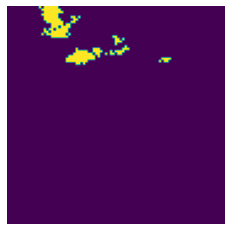

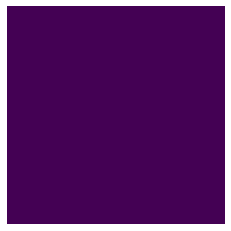

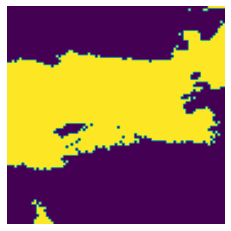

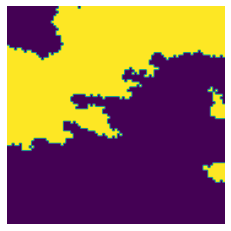

Batch 1 :


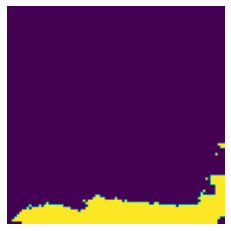

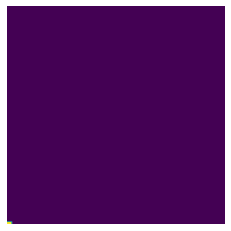

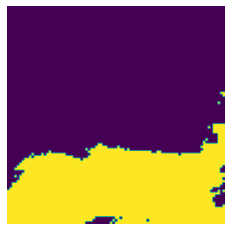

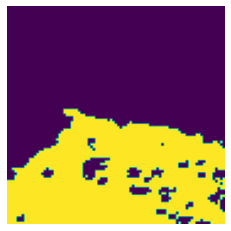

Batch 2 :


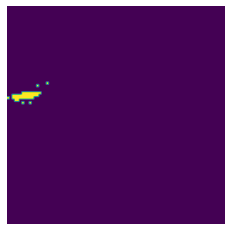

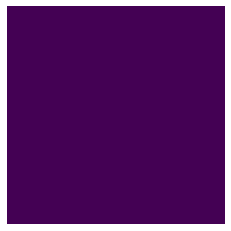

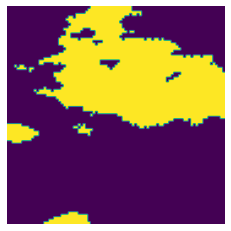

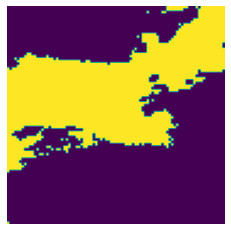

Batch 3 :


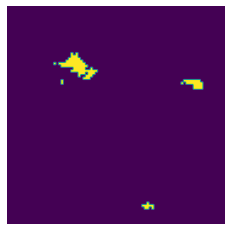

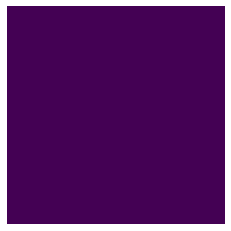

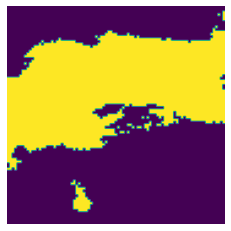

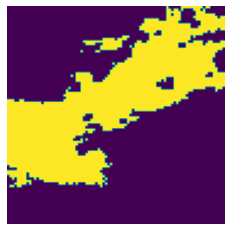

Batch 4 :


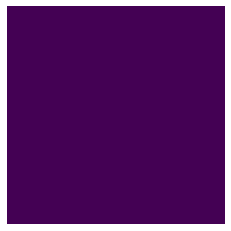

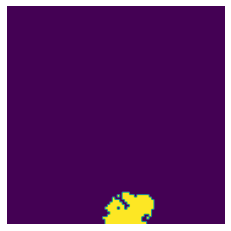

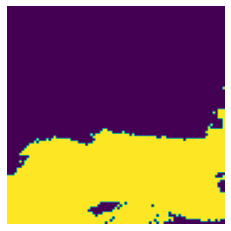

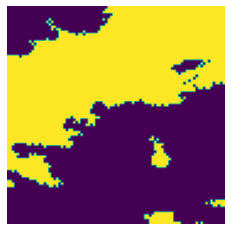

In [43]:
dl = DataLoader(ds, batch_sampler=sampler3, collate_fn=stack_samples)

count = 0
for sample in dl:
    print("Batch",count,":")
    count += 1
    mask = sample["mask"][0]
    ds.plot(mask)
    
    mask = sample["mask"][1]
    ds.plot(mask)
    
    mask = sample["mask"][2]
    ds.plot(mask)
    
    mask = sample["mask"][3]
    ds.plot(mask)
